In [1]:
%run T000_establish_connection.ipynb
%run T001_load_libraries.ipynb
call_graph = call_graph_par

ConnectionUnavailable: ('Cannot open connection to %r', ConnectionProfile('http://neo4j@localhost:7474'))

ConnectionUnavailable: ('Cannot open connection to %r', ConnectionProfile('http://neo4j@localhost:7474'))

In [16]:
df_time = call_graph.run("""
    MATCH (m:Molecule)
    RETURN DISTINCT m.point_in_time as time
    ORDER BY time ASC
""").to_data_frame()

time_list = df_time['time'].to_list()
del time_list[-1]

df_tu_prt = call_graph.run("""
    MATCH (:Molecule)-[t:PREDICTED_TRANSFORMATION]->(:Molecule)
    RETURN DISTINCT t.transformation_unit as transformation_unit
    """).to_data_frame()

for ele in time_list:
    transform_count_prt = call_graph.run("""
    MATCH (m:Molecule)-[t:PREDICTED_TRANSFORMATION]->(:Molecule)
    WHERE m.point_in_time = """ + str(ele) + """
    RETURN t.transformation_unit as transformation_unit, count(t.transformation_unit) as Count_prt_""" + str(ele) + """
    ORDER BY Count_prt_""" + str(ele) + """ DESC
    """).to_data_frame()

    df_tu_prt = pd.merge(df_tu_prt, transform_count_prt, on=["transformation_unit"])
    df_tu_prt['proportion_prt_' + str(ele)] = df_tu_prt['Count_prt_' + str(ele)]/df_tu_prt['Count_prt_' + str(ele)].sum()*100

# drop columns 'Count_'
# prt
droplist_prt = [i for i in df_tu_prt.columns if i.startswith('Count')]
df_tu_prt = df_tu_prt.drop(columns=droplist_prt, axis=1)

# make dataframe vertical
# prt
df_tu_prt = df_tu_prt.replace('', np.nan).set_index('transformation_unit').stack().reset_index(name='proportion').drop('level_1',1)

# add time to dataframe
# prt
times_repeat = len(df_tu_prt)/len(time_list)
times_list_prt = time_list * int(times_repeat)
df_tu_prt['point_in_time'] = times_list_prt

In [17]:
tu = 'H2 O1'
tu_2 = '-H2 -O1'

tu = tu
pick_tu = df_tu_prt[df_tu_prt.transformation_unit == tu]
res = stats.linregress(pick_tu.point_in_time, pick_tu.proportion)

tu_2 = tu_2
pick_tu_2 = df_tu_prt[df_tu_prt.transformation_unit == tu_2]
res_2 = stats.linregress(pick_tu_2.point_in_time, pick_tu_2.proportion)

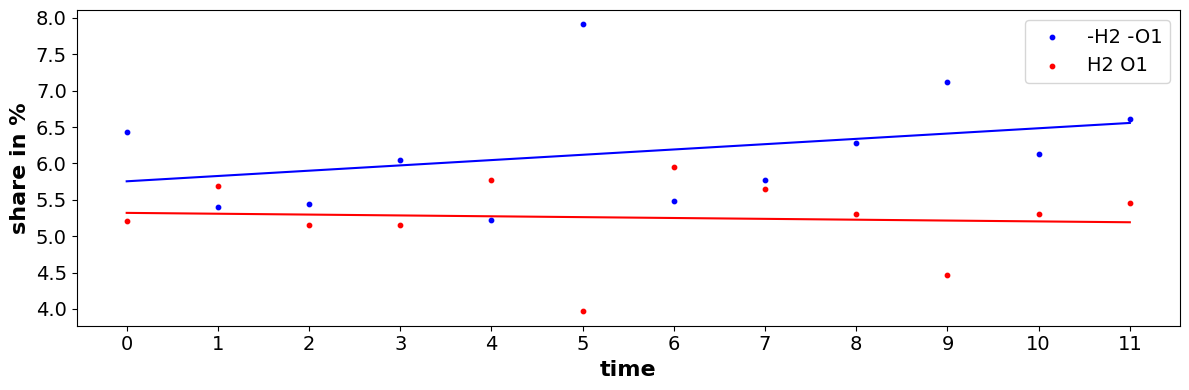

In [24]:
fig = plt.figure(figsize=(12,4))
plt.scatter(pick_tu.point_in_time, pick_tu.proportion, s=10, label=tu_2, c='b')
plt.plot(pick_tu.point_in_time, res.intercept + res.slope*pick_tu.point_in_time, c='b')
plt.scatter(pick_tu_2.point_in_time, pick_tu_2.proportion, s=10, label=tu, c='r')
plt.plot(pick_tu_2.point_in_time, res_2.intercept + res_2.slope*pick_tu_2.point_in_time, c='r')
plt.legend(fontsize=14)
plt.xlabel('time', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('share in %', fontsize=16, fontweight='bold')
plt.xticks(np.arange(min(pick_tu.point_in_time), max(pick_tu.point_in_time)+1, 1.0))

plt.tight_layout()
plt.savefig('results/occurence_development_single_tu.png', dpi=150 ,bbox_inches='tight')
plt.show()